In [ ]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=399b8119213bac2cc081bb4520c78089922e70e81178aca473f879c97a40259c
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=adc1b43472954167f58b981011e71b95a90bbf8a828ffb1c6cef0bdee5522107
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f53

In [ ]:
# ライブラリ読み込み
import glob
import cv2
import numpy as np
import os

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import segmentation_models_pytorch as smp

import albumentations as albu
import matplotlib.pyplot as plt

In [ ]:
# データ確認用
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [ ]:
# データ拡張
def get_training_augmentation():
    IMAGE_SIZE = 256
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, always_apply=True, border_mode=0),
        albu.RandomCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)

In [ ]:
# テンソル化
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

# 前処理
def get_preprocessing(preprocessing_fn):
    _transform = [
            albu.Lambda(image=preprocessing_fn),
            albu.Lambda(image=to_tensor, mask=to_tensor),
        ]
    return albu.Compose(_transform)

In [ ]:
# データセット
class Dataset(BaseDataset):
    CLASSES = ['background', 'chip']
    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [classes.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # mask
        mask = cv2.imread(self.masks_fps[i], 0)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)

In [ ]:
# モデルを宣言
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['chip']
ACTIVATION = 'sigmoid'  # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'
DECODER = 'unet'
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)
model = model.to("cuda")

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 301MB/s]


In [ ]:
train_dir = '/content/drive/MyDrive/chip-segmentation/train'
val_dir = '/content/drive/MyDrive/chip-segmentation/test'
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
# データセットを作成
train_dataset = Dataset(
    os.path.join(train_dir, 'images'),
    os.path.join(train_dir, 'masks'),
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=['chip'],
)
valid_dataset = Dataset(
    os.path.join(val_dir, 'images'),
    os.path.join(val_dir, 'masks'),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=['chip'],
)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/alb

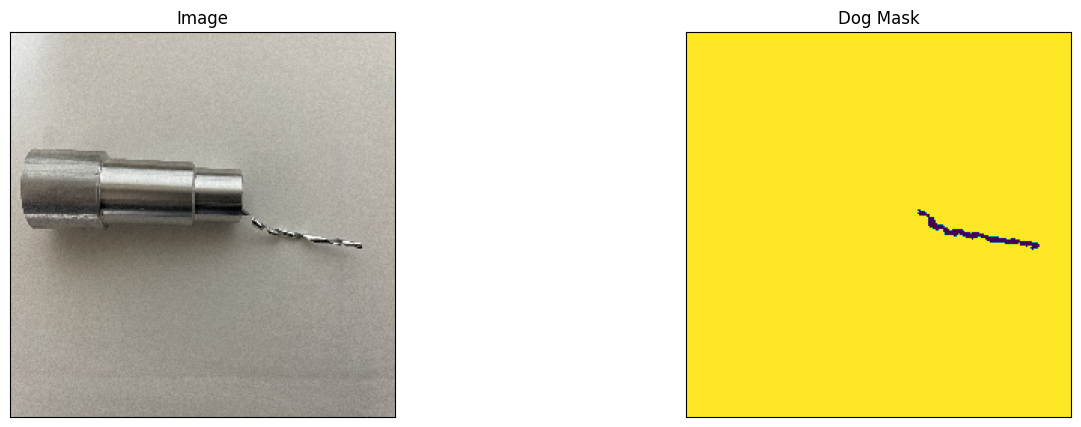

In [ ]:
# データ確認
dataset = Dataset(os.path.join(train_dir, 'images'), os.path.join(train_dir, 'masks'), classes=['chip'])

image, mask = dataset[5] # get some sample
visualize(
    image=image,
    dog_mask=mask.squeeze(),
)

In [ ]:
from segmentation_models_pytorch.utils.metrics import IoU
from segmentation_models_pytorch.utils import losses

In [ ]:
# 精度確認指標
metrics = [
    IoU(threshold=0.5),
]
# ロス
loss = losses.DiceLoss()
# 最適化関数
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.001),
])

In [ ]:
# 1Epochトレイン用
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)
valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [ ]:
# 学習 40EPoch 25Epochで学習率を下げる
max_score = 0
record_train_loss = []
record_valid_loss = []
for i in range(0, 400):

    print('\nEpoch: {}'.format(i))
    try:
        train_logs = train_epoch.run(train_loader)
        val_logs = valid_epoch.run(valid_loader)
        record_train_loss.append(train_logs)
        record_valid_loss.append(val_logs)
    except Exception as e:
        print(e)

    # do something (save model, change lr, etc.)
    if max_score < val_logs['iou_score']:
        max_score = val_logs['iou_score']
        torch.save(model, '20231031-0.pth')
        print('Model saved!')

    if i == 350:
        optimizer.param_groups[0]['lr'] = 1e-4
        print('Decrease decoder learning rate to 1e-4!')


Epoch: 0
valid: 100%|██████████| 10/10 [00:00<00:00, 47.31it/s, dice_loss - 0.02252, iou_score - 0.9973]
Model saved!

Epoch: 1
valid: 100%|██████████| 10/10 [00:00<00:00, 37.01it/s, dice_loss - 0.01963, iou_score - 0.9973]

Epoch: 2
valid: 100%|██████████| 10/10 [00:00<00:00, 37.54it/s, dice_loss - 0.01813, iou_score - 0.9973]

Epoch: 3
valid: 100%|██████████| 10/10 [00:00<00:00, 36.81it/s, dice_loss - 0.01543, iou_score - 0.9973]

Epoch: 4
valid: 100%|██████████| 10/10 [00:00<00:00, 45.30it/s, dice_loss - 0.0169, iou_score - 0.9973]

Epoch: 5
valid: 100%|██████████| 10/10 [00:00<00:00, 43.01it/s, dice_loss - 0.01676, iou_score - 0.9973]

Epoch: 6
valid: 100%|██████████| 10/10 [00:00<00:00, 45.50it/s, dice_loss - 0.01607, iou_score - 0.9973]

Epoch: 7
valid: 100%|██████████| 10/10 [00:00<00:00, 44.08it/s, dice_loss - 0.01528, iou_score - 0.9972]

Epoch: 8
valid: 100%|██████████| 10/10 [00:00<00:00, 42.72it/s, dice_loss - 0.01403, iou_score - 0.9972]

Epoch: 9
valid: 100%|██████████| 

In [ ]:
record_train_loss[1]

{'dice_loss': 0.023725271224975586, 'iou_score': 0.9885293394327164}

In [ ]:
record_train_dice = []
record_train_iou = []
for i in range(len(record_train_loss)):
  record_train_dice.append(record_train_loss[i]['dice_loss'])
  record_train_iou.append(record_train_loss[i]['iou_score'])
record_test_dice = []
record_test_iou = []
for i in range(len(record_train_loss)):
  record_test_dice.append(record_valid_loss[i]['dice_loss'])
  record_test_iou.append(record_valid_loss[i]['iou_score'])

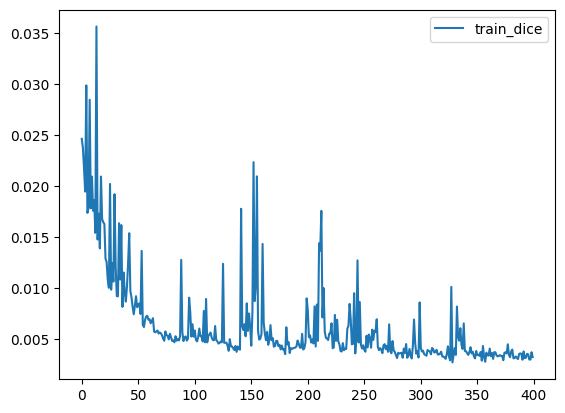

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
eppoch = np.arange(len(record_train_loss))
ax.plot(eppoch,record_train_dice,label='train_dice')
# ax.plot(eppoch,record_train_iou,label='train_iou')
ax.legend()
plt.show()

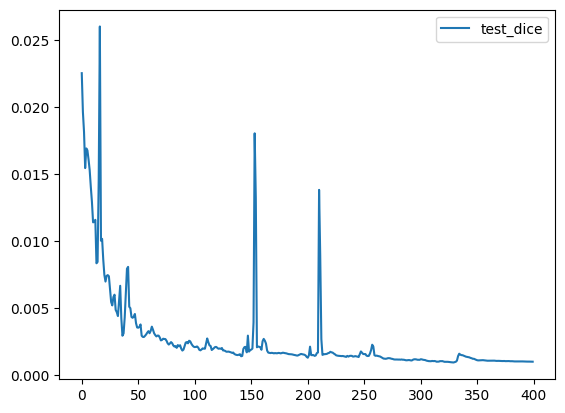

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
eppoch = np.arange(len(record_train_loss))
ax.plot(eppoch,record_test_dice,label='test_dice')
# ax.plot(eppoch,record_train_iou,label='train_iou')
# ax.set_xlim(350,400)
# ax.set_ylim(0.99,1)
ax.legend()
plt.show()

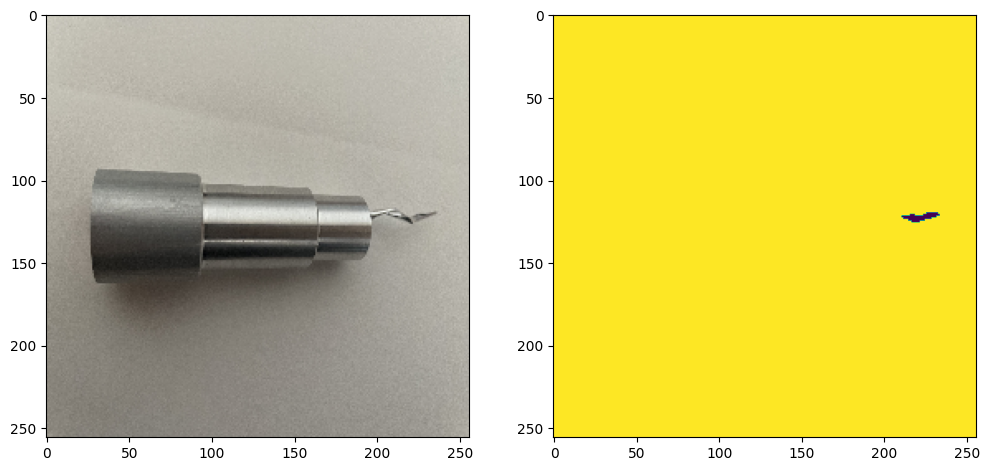

In [ ]:
# 画像読み込み

val_files = glob.glob('/content/drive/MyDrive/chip-segmentation/test/images/*')
f = val_files[2]
image_src = cv2.imread(f)
image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)

# 前処理
image = preprocessing_fn(image_src)
image = image.transpose(2, 0, 1).astype('float32')

# モデルで推論
image=torch.from_numpy(image).to(DEVICE).unsqueeze(0)
predict = model(image)
predict = predict.detach().cpu().numpy()[0].reshape((256,256))

# 0.5以上を1とする
predict_img = np.zeros([256,256]).astype(np.int8)
predict_img = np.where(predict>0.5, 1 , predict_img)

# 横並び
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.imshow(image_src)
ax2.imshow(predict_img)

In [ ]:
torch.save(model, '/content/drive/MyDrive/chip-segmentation/models/20231031-1.pth')